In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf

SEED = 1

In [2]:
df = pd.read_csv("94_character_TMNIST.csv", nrows=250000)
#df = df[df['labels'].str.contains('[A-Z]')]
df = df[df['labels'].str.isupper()]
df = df[df['names'].str.contains('sans', case=False)]

In [3]:
le=LabelEncoder()
df = df.assign(labels = le.fit_transform(df['labels']))

In [5]:
np.shape(df.iloc[:,2:].values)

(8242, 784)

In [4]:
# labels to predict
y = df.labels.values
# normalize features
#X = df.iloc[:,2:].values/255
# binarize image
#X = np.array([1 if val > 127 else 0 for val in df.iloc[:,2:].values])
X = (df.iloc[:,2:].values > 40).astype(int)
X = X.reshape(-1, 28, 28, 1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)
#X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train).type(torch.LongTensor), torch.from_numpy(y_test).type(torch.LongTensor)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


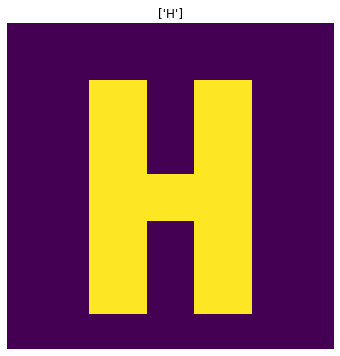

In [42]:
plt.imshow(X[4000])
plt.axis("off")
plt.title(str(le.inverse_transform([y[4000]])))
plt.show()

In [7]:
#from keras import backend as K
#K.set_image_data_format('channels_last')

import tensorflow as tf
#from keras_applications import resnet50
#from keras.applications import resnet50
from keras.applications import resnet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D


# Load the pre-trained ResNet50 model, excluding the top layer.
base_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers so they are not updated during training.
for layer in base_model.layers:
    layer.trainable = False

# Add a new top layer for classification.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(26, activation='softmax')(x)

# Define the new model with the ResNet50 base and the new top layers.
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a categorical crossentropy loss function and an Adam optimizer.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D

# Define the MobileNetV2 base model
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')

# Create a new model on top of the pre-trained MobileNetV2
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(26, activation='softmax'))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 26)                33306     
                                                                 
Total params: 2,291,290
Trainable params: 33,306
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
# normalize the pixel values
#X_train = X_train.astype('float32') / 255.0
#X_test = X_test.astype('float32') / 255.0

# reshape the images to (28, 28, 1)
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))
print(X_train.shape)

new_size = (224, 224)

'''
X_train_resized = np.empty((X_train.shape[0], new_size[0], new_size[1], 3))

for i in range(X_train.shape[0]):
    resized_img = cv2.resize(X_train[i], new_size, interpolation=cv2.INTER_NEAREST)
    if i==0:
        print(resized_img.shape)
    
    resized_img = np.expand_dims(resized_img, axis=-1)
    resized_img = np.repeat(resized_img, 3, axis=-1)
    X_train_resized[i] = resized_img

X_test_resized = np.empty((X_test.shape[0], new_size[0], new_size[1], 3))

for i in range(X_test.shape[0]):
    resized_img = cv2.resize(X_test[i], new_size, interpolation=cv2.INTER_NEAREST)
    resized_img = np.expand_dims(resized_img, axis=-1)
    resized_img = np.repeat(resized_img, 3, axis=-1)
    X_test_resized[i] = resized_img
'''
X_train_resized = np.empty((X_train.shape[0], new_size[0], new_size[1], 3))

for i in range(X_train.shape[0]):
    resized_img = cv2.resize(X_train[i], new_size, interpolation=cv2.INTER_NEAREST)
    resized_img = np.stack((resized_img,) * 3, axis=-1)
    X_train_resized[i] = resized_img
    if i==1:
        print(resized_img.shape)

X_test_resized = np.empty((X_test.shape[0], new_size[0], new_size[1], 3))

for i in range(X_test.shape[0]):
    resized_img = cv2.resize(X_test[i], new_size, interpolation=cv2.INTER_NEAREST)
    resized_img = np.stack((resized_img,) * 3, axis=-1)
    X_test_resized[i] = resized_img

# one-hot encoding
#y_train = np.array(y_train, dtype=np.uint8)

y_train = tf.one_hot(y_train.astype('uint8'), 26)
y_test = tf.one_hot(y_test.astype('uint8'), 26)
print(y_train.shape)

(6593, 28, 28, 1)
(224, 224, 3)
(6593, 26)


In [9]:
print(X_train_resized.shape)

(6593, 224, 224, 3)


In [10]:
# Train the model
history = model.fit(X_train_resized, y_train, epochs=10, validation_split=0.2)


Epoch 1/10
165/165 [==============================] - 1321s 8s/step - loss: 2.2700 - accuracy: 0.4725 - val_loss: 1.4229 - val_accuracy: 0.7051
Epoch 2/10
165/165 [==============================] - 1146s 7s/step - loss: 1.0205 - accuracy: 0.8218 - val_loss: 0.7174 - val_accuracy: 0.8855
Epoch 3/10
165/165 [==============================] - 1059s 6s/step - loss: 0.5955 - accuracy: 0.9031 - val_loss: 0.4797 - val_accuracy: 0.9007
Epoch 4/10
165/165 [==============================] - 1095s 7s/step - loss: 0.4059 - accuracy: 0.9302 - val_loss: 0.3405 - val_accuracy: 0.9409
Epoch 5/10
165/165 [==============================] - 1390s 8s/step - loss: 0.2983 - accuracy: 0.9492 - val_loss: 0.2567 - val_accuracy: 0.9560
Epoch 6/10
165/165 [==============================] - 1222s 7s/step - loss: 0.2377 - accuracy: 0.9598 - val_loss: 0.2147 - val_accuracy: 0.9636
Epoch 7/10
165/165 [==============================] - 1231s 7s/step - loss: 0.1986 - accuracy: 0.9655 - val_loss: 0.1845 - val_accuracy:

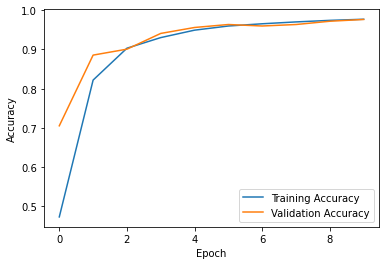

In [11]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
loss, accuracy = model.evaluate(X_test_resized, y_test)
print(f'Test set loss: {loss:.4f}')
print(f'Test set accuracy: {accuracy:.4f}')

52/52 [==============================] - 328s 6s/step - loss: 0.1359 - accuracy: 0.9685
Test set loss: 0.1359
Test set accuracy: 0.9685


In [41]:
# Load and preprocess the image
img = cv2.imread('letter_H.png', cv2.IMREAD_GRAYSCALE)
#img = cv2.resize(img, (28, 28))
img = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
print(img.shape)
_, binar = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
print(binar)
img = np.stack((binar,) * 3, axis=-1)
print(img.shape)
#binarize
#_, binar = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)


#img = np.expand_dims(binar, axis=-1)
#img = img / 255.0

# Get the predicted class probabilities
probs = model.predict(np.array([img]))

# Get the index of the class with the highest probability
pred_idx = np.argmax(probs)

# Map the index to the corresponding letter label
#label = [k for k, v in train_generator.class_indices.items() if v == pred_idx][0]

print("Predicted letter: ")
print(chr(ord('A')+pred_idx))

(224, 224)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(224, 224, 3)
1/1 [==============================] - 0s 365ms/step
Predicted letter: 
U


In [43]:
cv2.imshow('Binarized Image', binar)
cv2.waitKey(0)
cv2.destroyAllWindows()

feiyang stuff


In [31]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

In [32]:
def find_grid(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    tiles = []
    for c in contours:
        area = cv2.contourArea(c)
        if area > 1000 and area < 5000:
            #calculate accuracy as a percent of contour perimeter
            tiles.append(c)
            accuracy=0.03*cv2.arcLength(c,True)
            approx=cv2.approxPolyDP(c,accuracy,True)
            #cv2.drawContours(image,[approx],0,(0,255,0),2)
            #cv2.imshow('Approx polyDP', image)

    cv2.imshow("Final Image", image)
    plt.imshow(image)
    return tiles

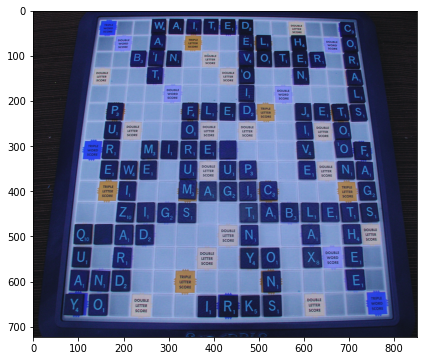

In [33]:
test_path = 'data/board2.png'
test_img = cv2.imread(test_path)

g = find_grid(test_img)

In [34]:
import math
def crop_contour(contours, img):
    img_arr = []
    rows = math.ceil(len(g)/6)
    num = 0
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        ROI = img[y:y+h, x:x+w]
        img_arr.append(ROI)
        #plt.subplot(rows,6,num+1)
        #plt.axis('off')
        #plt.imshow(ROI)
        num += 1
    return img_arr


In [35]:
rgb_images = crop_contour(g, test_img)

In [39]:
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in rgb_images]
imgs = [cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST) for img in imgs]
true_labels = ['.','I','K','S','O','R','Y','N','D','N','A','E','.','.','Y','O','X','R','U','E','N','A','D','A','H','-','-','Q','S','T','E','B','A','T','S','G','L','I','Z','G','G','I','A','C','I','.','.','A','U','N','E','P','=','E','W','E','F','V','E','R','-','-','I','M','R','=','I','O','U','S','T','E','J','.','.','D','E','L','F','P','L','I','A','N','R','T','N','B','=','=','=','=','E','I','T','A','=']

# Define threshold value
thresh_value = 80

with open("output.txt", "w") as f:
    print("", file = f)

# Iterate over list of grayscale images
for i in range(len(imgs)):
    # Apply thresholding to binarize the image
    _, bin_image = cv2.threshold(imgs[i], thresh_value, 1, cv2.THRESH_BINARY)
    bin_image = np.stack((imgs[i],) * 3, axis=-1)
    if i == 2:
        print(bin_image)
    #kernel = np.ones((2,2), np.uint8)
    #eroded = cv2.erode(bin_image, kernel, iterations=1)
    #kernel = np.ones((3,3), np.uint8)
    #dilated = cv2.dilate(eroded, kernel, iterations=1)
    
    # Replace original image with binarized image in list
    imgs[i] = bin_image

#print("greyscale", imgs[2])
with open("output.txt", "w") as f:
    for i in range(len(imgs)):
        print(imgs[i], file=f)
#imgs = np.array([int(np.expand_dims(img, axis=-1) < 127) for img in imgs])
imgs = np.array([np.expand_dims(img, axis=-1) for img in imgs])


# Get the predicted class probabilities for all the images
probs = model.predict(imgs)

# Get the indices of the classes with the highest probability for all the images
pred_indices = np.argmax(probs, axis=1)

# Map the indices to the corresponding letter labels
labels = [chr(ord('A')+i) for i in pred_indices]

print("Predicted letters: ")
print(labels)
print(true_labels)
print(sum((np.array(true_labels)==np.array(labels)))/len(true_labels))

[[[151 151 151]
  [151 151 151]
  [151 151 151]
  ...
  [160 160 160]
  [160 160 160]
  [160 160 160]]

 [[151 151 151]
  [151 151 151]
  [151 151 151]
  ...
  [160 160 160]
  [160 160 160]
  [160 160 160]]

 [[151 151 151]
  [151 151 151]
  [151 151 151]
  ...
  [160 160 160]
  [160 160 160]
  [160 160 160]]

 ...

 [[131 131 131]
  [131 131 131]
  [131 131 131]
  ...
  [161 161 161]
  [161 161 161]
  [161 161 161]]

 [[131 131 131]
  [131 131 131]
  [131 131 131]
  ...
  [161 161 161]
  [161 161 161]
  [161 161 161]]

 [[131 131 131]
  [131 131 131]
  [131 131 131]
  ...
  [161 161 161]
  [161 161 161]
  [161 161 161]]]


InvalidArgumentError: Graph execution error:

Detected at node 'model/conv1_pad/Pad' defined at (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\chees\AppData\Local\Temp\ipykernel_16968\1131617900.py", line 33, in <cell line: 33>
      probs = model.predict(imgs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\layers\reshaping\zero_padding2d.py", line 143, in call
      return backend.spatial_2d_padding(
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py", line 3770, in spatial_2d_padding
      return tf.compat.v1.pad(x, pattern)
Node: 'model/conv1_pad/Pad'
The first dimension of paddings must be the rank of inputs[4,2] [32,224,224,3,1]
	 [[{{node model/conv1_pad/Pad}}]] [Op:__inference_predict_function_24413]

In [ ]:
#albumentations or pytorch transform
#figure out rgb
#random affine transform and rotation and scaling
#add number on the bottom right


In [43]:
img = cv2.resize(img, (28, 28))
img = np.expand_dims(img, axis=-1)
img = img / 255.0

# Get the predicted class probabilities
probs = model.predict(np.array([img]))

# Get the index of the class with the highest probability
pred_idx = np.argmax(probs)

# Map the index to the corresponding letter label
#label = [k for k, v in train_generator.class_indices.items() if v == pred_idx][0]

print("Predicted letter: ")
print(chr(ord('A')+pred_idx))

1/1 [==============================] - 0s 53ms/step
Predicted letter: 
J


trash 

In [127]:
from keras.datasets import mnist
(x_train_m, y_train_m_start), (x_test_m, y_test_m_start) = mnist.load_data()
x_train_m[0].shape
X_train_m = x_train_m.astype('float32') / 255.0
X_test_m = x_test_m.astype('float32') / 255.0

# Reshape the images to (28, 28, 1)
X_train_m = np.reshape(X_train_m, (len(X_train_m), 28, 28, 1))
X_test_m = np.reshape(X_test_m, (len(X_test_m), 28, 28, 1))
print(X_train_m.shape)

# Convert the labels to one-hot encoded vectors
y_train_m = to_categorical(y_train_m_start, 26)
y_test_m = to_categorical(y_test_m_start, 26)
print(y_train_m.shape)

(60000, 28, 28, 1)
(60000, 26)


In [83]:

from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.metrics import roc_auc_score, accuracy_score
'''
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))



'''
model = Sequential()
model.add(Conv2D(32,(4,4),input_shape = (28,28,1),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(94, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0         
                                                                 
 flatten_5 (Flatten)         (None, 1600)             

ValueError: in user code:

    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\chees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 94) are incompatible


In [81]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test set loss: {loss:.4f}')
print(f'Test set accuracy: {accuracy:.4f}')

52/52 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.0352
Test set loss: 0.0000
Test set accuracy: 0.0352


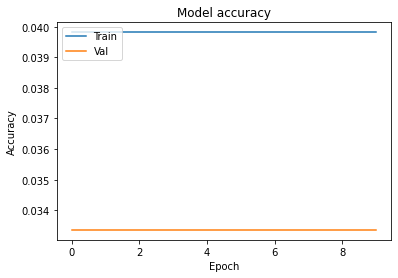

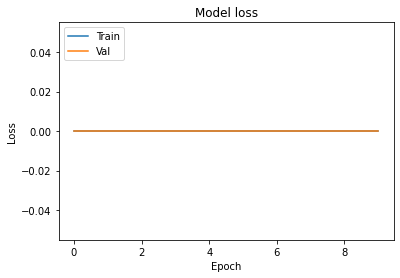

In [82]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

test other